<a href="https://colab.research.google.com/github/AntoninaRemizova/Minor/blob/main/%D0%A0%D0%B5%D0%BC%D0%B8%D0%B7%D0%BE%D0%B2%D0%B0_%D0%94%D0%97_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIR-модель
## Импортируем библиотеки и датасет

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

url = "https://raw.githubusercontent.com/AntoninaRemizova/Minor/main/Japan.xlsx"
df = pd.read_excel(url)
df

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Япония,20.07.2020,25680,19603.0,988,418,392.0,2,127110047,562726,12114
1,Япония,21.07.2020,26312,20001.0,989,632,398.0,1,127110047,579083,16357
2,Япония,22.07.2020,27107,20482.0,990,795,481.0,1,127110047,587393,8310
3,Япония,23.07.2020,28088,20878.0,992,981,396.0,2,127110047,593088,5695
4,Япония,24.07.2020,28867,21173.0,995,779,295.0,3,127110047,602618,9530
...,...,...,...,...,...,...,...,...,...,...,...
604,Япония,16.03.2022,5913591,NaN,26625,57822,NaN,163,127110047,40063837,156343
605,Япония,17.03.2022,5967069,NaN,26796,53478,NaN,171,127110047,40240745,176908
606,Япония,18.03.2022,6016178,NaN,26952,49109,NaN,156,127110047,40335554,94809
607,Япония,19.03.2022,6060771,NaN,27056,44593,NaN,104,127110047,40388920,53366


## Сокращаем датасет
Удаляем столбцы, которые не понадобятся для дальнейших вычислений.


In [2]:
df.drop(['Страна'], axis=1, inplace=True)
df.drop(['Смертей за день'], axis=1, inplace=True)
df.drop(['Тестов'], axis=1, inplace=True)
df.drop(['Тестов за день'], axis=1, inplace=True)
df

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны
0,20.07.2020,25680,19603.0,988,418,392.0,127110047
1,21.07.2020,26312,20001.0,989,632,398.0,127110047
2,22.07.2020,27107,20482.0,990,795,481.0,127110047
3,23.07.2020,28088,20878.0,992,981,396.0,127110047
4,24.07.2020,28867,21173.0,995,779,295.0,127110047
...,...,...,...,...,...,...,...
604,16.03.2022,5913591,NaN,26625,57822,NaN,127110047
605,17.03.2022,5967069,NaN,26796,53478,NaN,127110047
606,18.03.2022,6016178,NaN,26952,49109,NaN,127110047
607,19.03.2022,6060771,NaN,27056,44593,NaN,127110047


## Выявим пропущенные значения

In [3]:
columns = df.columns.to_list()
nan_values = df[columns].isnull().sum()
print("Пропуски в столбцах:")
print(nan_values.to_string())

Пропуски в столбцах:
Дата                       0
Заражений                  0
Выздоровлений            228
Смертей                    0
Заражений за день          0
Выздоровлений за день    228
Население страны           0


In [4]:
rows_with_nan = df[df[columns].isnull().any(axis=1)]
print("\nСтроки с пропусками:")
rows_with_nan


Строки с пропусками:


,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны
381,05.08.2021,987060,NaN,15239,15317,NaN,127110047
382,06.08.2021,1002867,NaN,15259,15807,NaN,127110047
383,07.08.2021,1018688,NaN,15273,15821,NaN,127110047
384,08.08.2021,1033214,NaN,15282,14526,NaN,127110047
385,09.08.2021,1045392,NaN,15294,12178,NaN,127110047
...,...,...,...,...,...,...,...
604,16.03.2022,5913591,NaN,26625,57822,NaN,127110047
605,17.03.2022,5967069,NaN,26796,53478,NaN,127110047
606,18.03.2022,6016178,NaN,26952,49109,NaN,127110047
607,19.03.2022,6060771,NaN,27056,44593,NaN,127110047


Временно уберем строки с пропусками, чтобы построить модель по имеющимся данным.

In [5]:
df = df.dropna().copy()
df

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны
0,20.07.2020,25680,19603.0,988,418,392.0,127110047
1,21.07.2020,26312,20001.0,989,632,398.0,127110047
2,22.07.2020,27107,20482.0,990,795,481.0,127110047
3,23.07.2020,28088,20878.0,992,981,396.0,127110047
4,24.07.2020,28867,21173.0,995,779,295.0,127110047
...,...,...,...,...,...,...,...
376,31.07.2021,926604,834811.0,15191,12422,3880.0,127110047
377,01.08.2021,936852,839090.0,15196,10248,4279.0,127110047
378,02.08.2021,945330,842624.0,15207,8478,3534.0,127110047
379,03.08.2021,957431,847717.0,15217,12101,5093.0,127110047


## Вычислим количество инфицированных (I) и количество восприимчивых (S)

In [6]:
df['I'] = df['Заражений'] - df['Выздоровлений'] - df['Смертей']
df['S'] = df['Население страны'] - df['Заражений']
df

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны,I,S
0,20.07.2020,25680,19603.0,988,418,392.0,127110047,5089.0,127084367
1,21.07.2020,26312,20001.0,989,632,398.0,127110047,5322.0,127083735
2,22.07.2020,27107,20482.0,990,795,481.0,127110047,5635.0,127082940
3,23.07.2020,28088,20878.0,992,981,396.0,127110047,6218.0,127081959
4,24.07.2020,28867,21173.0,995,779,295.0,127110047,6699.0,127081180
...,...,...,...,...,...,...,...,...,...
376,31.07.2021,926604,834811.0,15191,12422,3880.0,127110047,76602.0,126183443
377,01.08.2021,936852,839090.0,15196,10248,4279.0,127110047,82566.0,126173195
378,02.08.2021,945330,842624.0,15207,8478,3534.0,127110047,87499.0,126164717
379,03.08.2021,957431,847717.0,15217,12101,5093.0,127110047,94497.0,126152616


## Нормируем данные

In [19]:
N = df['Население страны'].iloc[0]
coef_norm = 100000
df['I_norm'] = df['I'] * coef_norm / N
df['S_norm'] = df['S'] * coef_norm / N
df['R_norm'] = df['Выздоровлений'] * coef_norm / N
df

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны,I,S,I_norm,S_norm,R_norm,Расчет
0,20.07.2020,25680,19603.0,988,418,392.0,127110047,5089.0,127084367,4.003617,99979.797034,15.422070,4.002809
1,21.07.2020,26312,20001.0,989,632,398.0,127110047,5322.0,127083735,4.186923,99979.299827,15.735184,4.186056
2,22.07.2020,27107,20482.0,990,795,481.0,127110047,5635.0,127082940,4.433166,99978.674384,16.113596,4.432221
3,23.07.2020,28088,20878.0,992,981,396.0,127110047,6218.0,127081959,4.891824,99977.902612,16.425138,4.890743
4,24.07.2020,28867,21173.0,995,779,295.0,127110047,6699.0,127081180,5.270236,99977.289757,16.657220,5.269040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,31.07.2021,926604,834811.0,15191,12422,3880.0,127110047,76602.0,126183443,60.264316,99271.022219,656.762404,59.825002
377,01.08.2021,936852,839090.0,15196,10248,4279.0,127110047,82566.0,126173195,64.956313,99262.959914,660.128778,64.477559
378,02.08.2021,945330,842624.0,15207,8478,3534.0,127110047,87499.0,126164717,68.837202,99256.290103,662.909046,68.325253
379,03.08.2021,957431,847717.0,15217,12101,5093.0,127110047,94497.0,126152616,74.342668,99246.770006,666.915810,73.782697


## Построим оценку параметра интенсивности выздоровления ($\gamma$)

In [23]:
gamma = sum(df['Выздоровлений за день'] * df['I']) / sum(df['I']**2)
print(f"Оценка параметра γ: {gamma:.6f}")
print(f"Средняя продолжительность заболевания: {1/gamma:.2f} дней")

Оценка параметра γ: 0.069816
Средняя продолжительность заболевания: 14.32 дней


## Восстановим пропущенные значения

In [26]:

mask = df['Выздоровлений за день'].isna()
df.loc[mask, 'Выздоровлений за день'] = gamma * df.loc[mask, 'I']

first_na = df['Выздоровлений'].isna().idxmax()

for i in range(first_na, len(df)):
    if pd.isna(df.at[i, 'Выздоровлений']):
        if i == 0:
            df.at[i, 'Выздоровлений'] = df.at[i, 'Выздоровлений за день']
        else:
            df.at[i, 'Выздоровлений'] = df.at[i-1, 'Выздоровлений'] + df.at[i, 'Выздоровлений за день']


df['I'] = df['Заражений'] - df['Выздоровлений'] - df['Смертей']


print("Статистика пропусков после заполнения:")
print(f"'Выздоровлений за день': {df['Выздоровлений за день'].isna().sum()} пропусков")
print(f"'Выздоровлений': {df['Выздоровлений'].isna().sum()} пропусков")


print("\nПример заполненных данных:")
print(df.loc[df['Выздоровлений за день'].isna().head(5), ['Дата', 'Заражений', 'Выздоровлений', 'Выздоровлений за день', 'I']])

Статистика пропусков после заполнения:
'Выздоровлений за день': 0 пропусков
'Выздоровлений': 0 пропусков

Пример заполненных данных:


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## Построим оценку параметра интенсивности заражения ($\beta$)

In [20]:
df['Расчет'] = df['S_norm'] * df['I_norm'] / coef_norm
beta = sum(df['Заражений за день'] * df['Расчет']) / sum(df['Расчет']**2)
print(f"Оценка параметра β: {beta:.6f}")

Оценка параметра β: 105.046641


In [13]:
lm = smf.ols(formula='Q("Заражений за день") ~ 0 + Расчет', data=df).fit()
lm.params
print(lm.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Q("Заражений за день")   R-squared (uncentered):                   0.882
Model:                                OLS   Adj. R-squared (uncentered):              0.882
Method:                     Least Squares   F-statistic:                              2837.
Date:                    Sat, 12 Apr 2025   Prob (F-statistic):                   2.38e-178
Time:                            12:57:07   Log-Likelihood:                         -3220.2
No. Observations:                     381   AIC:                                      6442.
Df Residuals:                         380   BIC:                                      6446.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [24]:

def sir_model(params, initial_conditions, days, gamma):
    beta = params[0]
    S, I = np.zeros(days), np.zeros(days)
    S[0], I[0] = initial_conditions

    for t in range(1, days):
        dS = -beta * S[t-1] * I[t-1] / coef_norm
        dI = beta * S[t-1] * I[t-1] / coef_norm - gamma * I[t-1]
        S[t] = S[t-1] + dS
        I[t] = I[t-1] + dI

    return I



<ipython-input-24-8a83da894664>:7: RuntimeWarning: overflow encountered in scalar multiply
  dS = -beta * S[t-1] * I[t-1] / coef_norm
<ipython-input-24-8a83da894664>:8: RuntimeWarning: overflow encountered in scalar multiply
  dI = beta * S[t-1] * I[t-1] / coef_norm - gamma * I[t-1]
<ipython-input-24-8a83da894664>:8: RuntimeWarning: invalid value encountered in scalar subtract
  dI = beta * S[t-1] * I[t-1] / coef_norm - gamma * I[t-1]


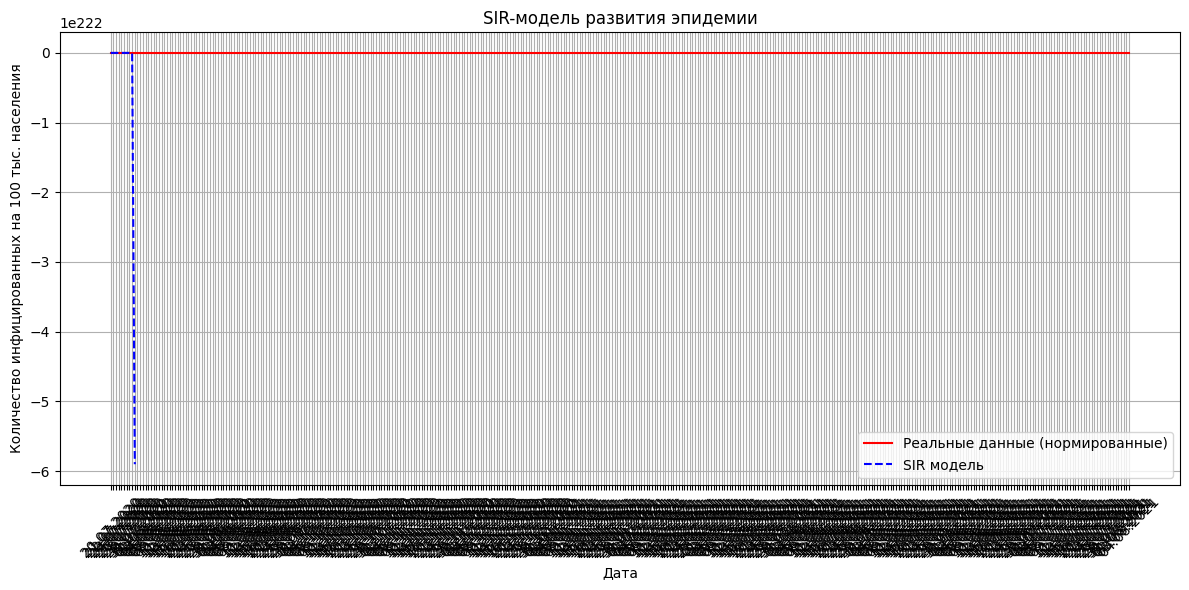

In [25]:

plt.figure(figsize=(12, 6))
plt.plot(df['Дата'], df['I_norm'], 'r-', label='Реальные данные (нормированные)')
predicted_I = sir_model([beta], (df['S_norm'].iloc[0], df['I_norm'].iloc[0]), len(df), gamma)
plt.plot(df['Дата'], predicted_I, 'b--', label='SIR модель')
plt.xlabel('Дата')
plt.ylabel('Количество инфицированных на 100 тыс. населения')
plt.title('SIR-модель развития эпидемии')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()